# 2021–2022 Football Player Stats — EDA → League-Adjusted KPIs → “Misused” Players

This notebook reproduces the full pipeline:

1. Load the dataset (Excel)
2. Basic EDA (counts by position & competition)
3. Inter-feature relationships (correlation + heatmap)
4. League/competition adjustment (per-league z-scoring)
5. Position feature importance (logistic regression coefficients)
6. Build 3 KPI formulas (Attack / Midfield / Defence)
7. Score every player, predict “stat-accurate” role, and flag potential “misuse”
8. Export results to Excel

> **Input file expected:** `2021-2022 Football Player Stats.xlsx` in the same folder as this notebook  


In [67]:
# === Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)


In [68]:
# === Load data ===
# Option A: file in same folder as notebook
local_path = Path("2021-2022 Football Player Stats.xlsx")

file_path = local_path 
xl = pd.ExcelFile(file_path)
print("Sheets:", xl.sheet_names)

df_raw = pd.read_excel(file_path, sheet_name=xl.sheet_names[0])
print("Shape:", df_raw.shape)
df_raw.head()


Sheets: ['2021-2022 Football Player Stats']
Shape: (2704, 54)


,Rk,Player,Comp,Pos,90s,Goals,SoT%,G/SoT,ShoDist,PasTotCmp%,PasTotDist,Assists,PasAss,Pas3rd,PPA,TB,PasPress,Sw,PasCrs,SCA,ScaDrib,ScaDef,GCA,GcaPassLive,GcaPassDead,GcaDrib,GcaSh,GcaDef,Tkl,TklWon,TklDef3rd,TklMid3rd,TklAtt3rd,TklDri,Press%,PresDef3rd,PresMid3rd,PresAtt3rd,Blocks,Int,Tkl+Int,Clr,Touches,TouDefPen,TouDef3rd,TouMid3rd,TouAtt3rd,TouAttPen,DriSucc%,DriPast,TklW,PKwon,Recov,AerWon%
0,1,Max Aarons,Premier League,DF,32.0,0.00,15.4,0.00,20.5,75.5,574.1,0.06,0.59,1.56,1.13,0.06,5.41,0.59,1.41,1.19,0.09,0.00,0.16,0.16,0.00,0.00,0.00,0.0,2.16,1.16,1.56,0.59,0.00,1.16,26.0,7.97,4.38,1.22,2.69,1.75,3.91,2.19,58.0,5.06,23.3,23.8,15.00,0.91,42.3,1.09,1.16,0.00,5.53,22.7
1,2,Yunis Abdelhamid,Ligue 1,DF,33.1,0.06,33.3,0.33,18.7,82.4,835.8,0.00,0.24,2.45,0.18,0.00,5.68,1.66,0.06,0.63,0.09,0.09,0.03,0.00,0.00,0.03,0.00,0.0,1.87,1.39,1.24,0.60,0.03,0.39,35.9,7.61,5.14,0.88,1.87,3.11,4.98,3.20,57.3,8.28,32.8,25.7,2.90,0.85,72.7,0.48,1.39,0.00,6.77,59.8
2,9,Luis Abram,La Liga,DF,6.2,0.00,0.0,0.00,7.0,88.2,696.8,0.00,0.00,1.29,0.00,0.00,1.61,1.13,0.00,0.48,0.00,0.00,0.16,0.00,0.00,0.00,0.16,0.0,1.13,0.97,0.81,0.16,0.16,0.48,37.1,2.26,3.23,0.16,2.10,1.77,2.90,6.29,46.8,10.20,30.0,18.2,1.13,0.81,0.0,0.00,0.97,0.00,4.03,44.4
3,10,Francesco Acerbi,Serie A,DF,28.2,0.14,43.8,0.57,9.2,90.3,1345.5,0.00,0.21,4.33,0.21,0.07,5.96,2.66,0.04,0.64,0.00,0.00,0.07,0.04,0.00,0.00,0.00,0.0,0.96,0.43,0.64,0.32,0.00,0.32,29.1,3.05,2.41,0.39,1.70,1.70,2.66,4.08,80.2,12.30,42.0,41.4,2.30,0.78,75.0,0.11,0.43,0.04,10.70,64.0
4,13,Marcos Acuï¿½a,La Liga,DF,25.1,0.04,29.4,0.20,22.1,79.4,1283.3,0.12,1.63,4.10,1.67,0.12,6.77,4.22,4.94,2.63,0.04,0.00,0.12,0.04,0.08,0.00,0.00,0.0,2.31,1.55,1.31,0.60,0.40,0.84,34.0,5.30,4.74,1.67,1.43,1.24,3.55,1.20,88.0,2.75,27.5,41.3,25.60,0.92,69.2,1.91,1.55,0.00,8.92,47.1


In [69]:
# === Basic cleaning & helper columns ===
df = df_raw.copy()

# strip whitespace from text columns
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

def pos_group(pos: str) -> str:
    pos = str(pos)
    if "FW" in pos:
        return "FW"
    if "MF" in pos:
        return "MF"
    if "DF" in pos:
        return "DF"
    return "Other"

df["PosGroup"] = df["Pos"].apply(pos_group)

df[["Player","Comp","Pos","PosGroup"]].head()



,Player,Comp,Pos,PosGroup
0,Max Aarons,Premier League,DF,DF
1,Yunis Abdelhamid,Ligue 1,DF,DF
2,Luis Abram,La Liga,DF,DF
3,Francesco Acerbi,Serie A,DF,DF
4,Marcos Acuï¿½a,La Liga,DF,DF


,Pos,Count
0,DF,1040
1,MF,903
2,FW,761


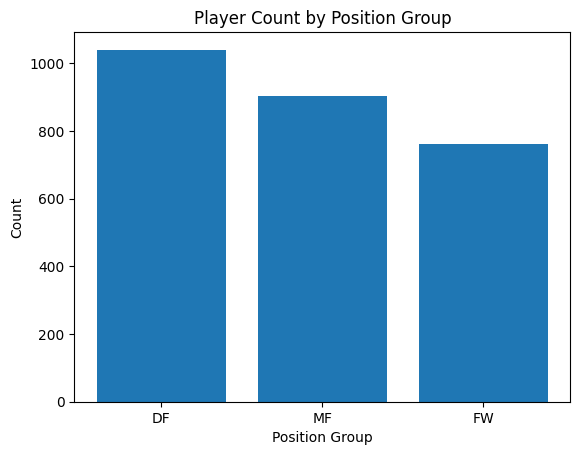

,Comp,Count
0,Serie A,583
1,La Liga,573
2,Ligue 1,562
3,Premier League,504
4,Bundesliga,482


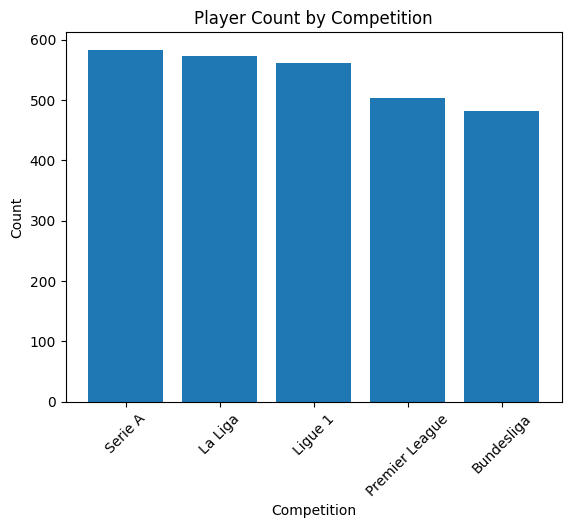

In [70]:
# === EDA: counts by position and competition ===
pos_counts = df["Pos"].value_counts().rename_axis("Pos").reset_index(name="Count")
comp_counts = df["Comp"].value_counts().rename_axis("Comp").reset_index(name="Count")

display(pos_counts)
counts = df["PosGroup"].value_counts()

plt.figure()
plt.bar(counts.index, counts.values)
plt.title("Player Count by Position Group")
plt.xlabel("Position Group")
plt.ylabel("Count")
plt.show()
display(comp_counts)

comp_counts = df["Comp"].value_counts()

plt.figure()
plt.bar(comp_counts.index, comp_counts.values)
plt.title("Player Count by Competition")
plt.xticks(rotation=45)
plt.xlabel("Competition")
plt.ylabel("Count")
plt.show()


Numeric feature count: 50


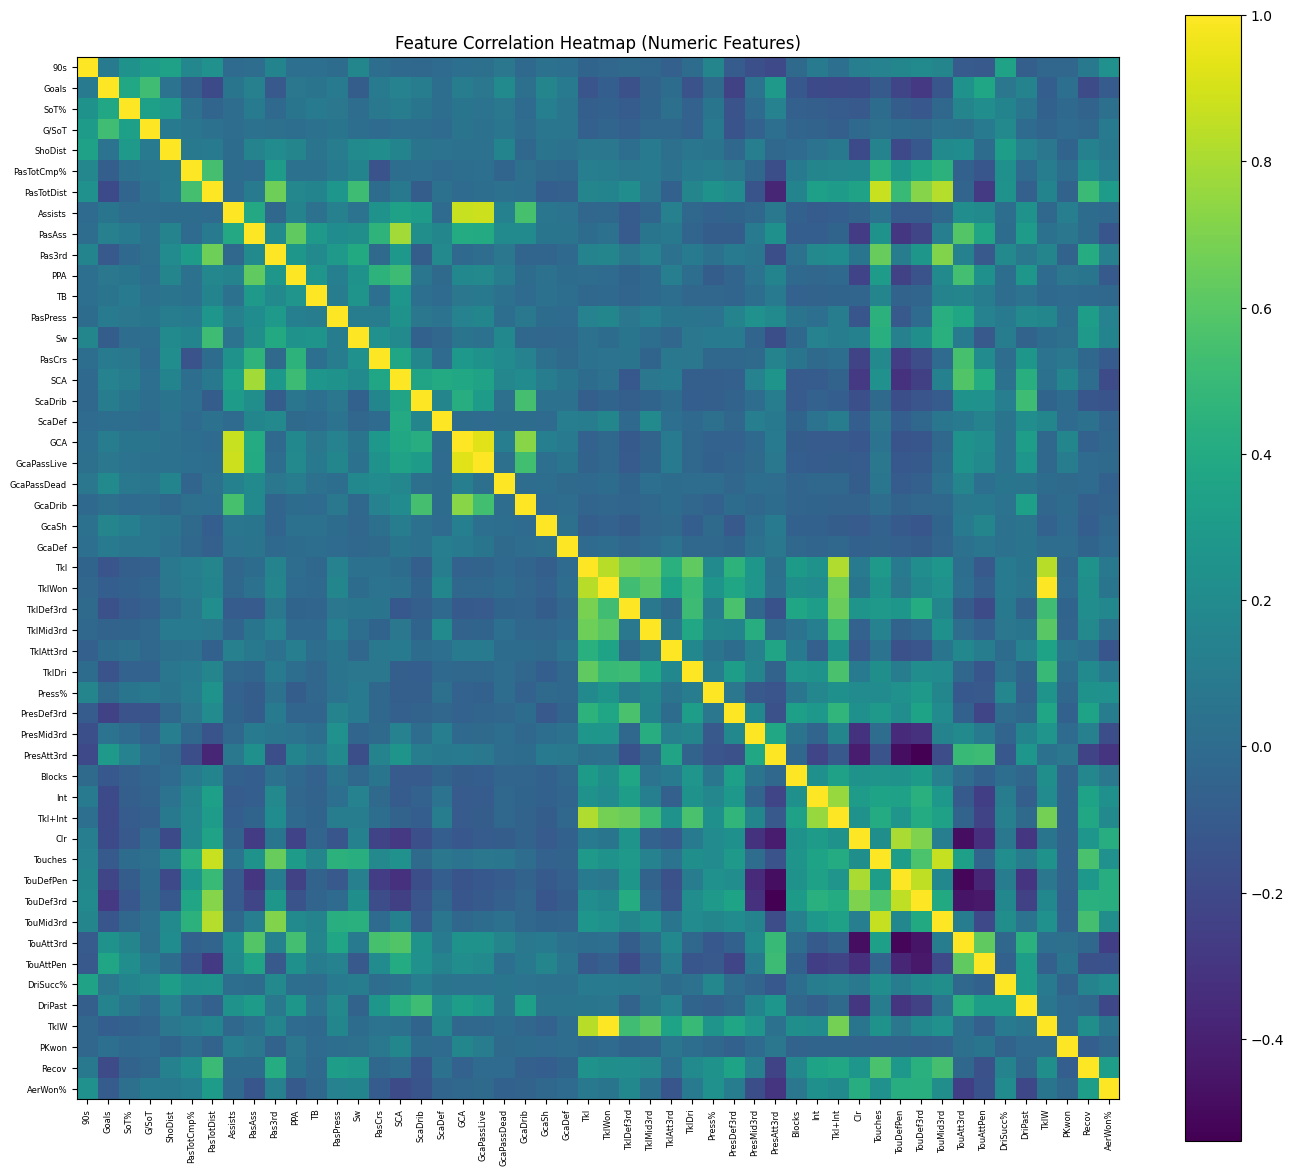

In [71]:
# === Correlation analysis (numeric features only) ===
id_cols = ["Rk","Player","Comp","Pos","PosGroup"]
numeric_cols = [c for c in df.columns if c not in id_cols and pd.api.types.is_numeric_dtype(df[c])]

print("Numeric feature count:", len(numeric_cols))

# === Correlation heatmap ===
plt.figure(figsize=(14,12))
plt.imshow(corr.values)  # default colormap
plt.title("Feature Correlation Heatmap (Numeric Features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.index)), corr.index, fontsize=6)
plt.colorbar()
plt.tight_layout()
plt.show()



In [59]:
# === League/competition scaling (per-Comp z-score) ===
# This makes features comparable across leagues by removing league-specific mean/variance.
df_adj = df.copy()

for col in numeric_cols:
    grp = df_adj.groupby("Comp")[col]
    mean = grp.transform("mean")
    std = grp.transform("std").replace(0, np.nan)
    df_adj[col] = (df_adj[col] - mean) / std

# Fill NaNs (e.g., if std=0) with 0 after z-scoring
df_adj[numeric_cols] = df_adj[numeric_cols].fillna(0.0)

df_adj[numeric_cols].describe().T.head()


,count,mean,std,min,25%,50%,75%,max
90s,2704.0,1.051099e-17,0.99926,-1.389846,-0.954070,-0.121458,0.803763,2.309072
Goals,2704.0,-1.051099e-17,0.99926,-0.612904,-0.525170,-0.410951,0.198959,18.141323
SoT%,2704.0,1.051099e-17,0.99926,-1.286806,-1.159553,0.034426,0.591760,3.831839
G/SoT,2704.0,7.883240e-18,0.99926,-0.822102,-0.768001,-0.452790,0.519562,7.017294
ShoDist,2704.0,2.102197e-17,0.99926,-2.135746,-0.486272,0.135519,0.681568,4.919030


In [60]:
# === Position feature importance via logistic regression ===
X = df_adj[numeric_cols].values
y = df_adj["PosGroup"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=5000,solver="lbfgs"))
])

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

          DF       0.89      0.85      0.87       260
          FW       0.76      0.82      0.79       190
          MF       0.78      0.77      0.78       226

    accuracy                           0.82       676
   macro avg       0.81      0.81      0.81       676
weighted avg       0.82      0.82      0.82       676



In [61]:
# === Extract per-position coefficients (feature "importance") ===
lr = clf.named_steps["lr"]
classes = lr.classes_
coefs = lr.coef_  # shape (n_classes, n_features)

importance_rows = []
for i, cls in enumerate(classes):
    for feat, coef in zip(numeric_cols, coefs[i]):
        importance_rows.append({"PosGroup": cls, "Feature": feat, "Coef": coef, "AbsCoef": abs(coef)})

imp_df = pd.DataFrame(importance_rows)

def top_features_for_group(group: str, n: int = 12) -> pd.DataFrame:
    g = imp_df[imp_df["PosGroup"] == group].sort_values("AbsCoef", ascending=False).head(n).copy()
    return g[["Feature","Coef","AbsCoef"]]

top_fw = top_features_for_group("FW", 10)
top_mf = top_features_for_group("MF", 10)
top_df = top_features_for_group("DF", 10)

print("Top FW features:")
display(top_fw)

print("Top MF features:")
display(top_mf)

print("Top DF features:")
display(top_df)

# A compact wide table
wide = pd.DataFrame({
    "FW_feature": top_fw["Feature"].values,
    "FW_coef": top_fw["Coef"].round(3).values,
    "MF_feature": top_mf["Feature"].values,
    "MF_coef": top_mf["Coef"].round(3).values,
    "DF_feature": top_df["Feature"].values,
    "DF_coef": top_df["Coef"].round(3).values,
})
display(wide)


Top FW features:


,Feature,Coef,AbsCoef
56,PasTotDist,-1.469016,1.469016
85,Int,-0.597340,0.597340
87,Clr,-0.562619,0.562619
88,Touches,0.546257,0.546257
51,Goals,0.523982,0.523982
83,PresAtt3rd,0.441317,0.441317
98,Recov,-0.394436,0.394436
89,TouDefPen,0.369735,0.369735
74,Tkl,-0.356855,0.356855
79,TklDri,-0.309282,0.309282


Top MF features:


,Feature,Coef,AbsCoef
140,TouDef3rd,-0.922376,0.922376
142,TouAtt3rd,-0.620512,0.620512
132,PresMid3rd,0.523433,0.523433
106,PasTotDist,0.508250,0.508250
148,Recov,0.404058,0.404058
135,Int,0.364720,0.364720
141,TouMid3rd,0.362117,0.362117
138,Touches,-0.348659,0.348659
136,Tkl+Int,-0.320433,0.320433
118,GCA,0.316608,0.316608


Top DF features:


,Feature,Coef,AbsCoef
40,TouDef3rd,1.111874,1.111874
6,PasTotDist,0.960766,0.960766
32,PresMid3rd,-0.707377,0.707377
1,Goals,-0.659731,0.659731
42,TouAtt3rd,0.524694,0.524694
33,PresAtt3rd,-0.501513,0.501513
18,GCA,-0.414484,0.414484
37,Clr,0.380000,0.380000
14,PasCrs,0.368912,0.368912
12,PasPress,-0.345378,0.345378


,FW_feature,FW_coef,MF_feature,MF_coef,DF_feature,DF_coef
0,PasTotDist,-1.469,TouDef3rd,-0.922,TouDef3rd,1.112
1,Int,-0.597,TouAtt3rd,-0.621,PasTotDist,0.961
2,Clr,-0.563,PresMid3rd,0.523,PresMid3rd,-0.707
3,Touches,0.546,PasTotDist,0.508,Goals,-0.660
4,Goals,0.524,Recov,0.404,TouAtt3rd,0.525
5,PresAtt3rd,0.441,Int,0.365,PresAtt3rd,-0.502
6,Recov,-0.394,TouMid3rd,0.362,GCA,-0.414
7,TouDefPen,0.370,Touches,-0.349,Clr,0.380
8,Tkl,-0.357,Tkl+Int,-0.320,PasCrs,0.369
9,TklDri,-0.309,GCA,0.317,PasPress,-0.345


In [62]:
# === Build KPI formulas from top coefficients ===
# We take top-N features per position group and normalize weights by sum(abs(coef))
def kpi_weights(group: str, n: int = 8) -> pd.DataFrame:
    g = imp_df[imp_df["PosGroup"] == group].sort_values("AbsCoef", ascending=False).head(n).copy()
    g["Weight"] = g["Coef"] / g["AbsCoef"].sum()
    return g[["Feature","Weight","Coef","AbsCoef"]]

kpi_fw = kpi_weights("FW", 8)  # Attack KPI weights
kpi_mf = kpi_weights("MF", 8)  # Midfield KPI weights
kpi_df = kpi_weights("DF", 8)  # Defence KPI weights

print("Attack KPI weights:")
display(kpi_fw[["Feature","Weight"]].assign(Weight=lambda d: d["Weight"].round(4)))

print("Midfield KPI weights:")
display(kpi_mf[["Feature","Weight"]].assign(Weight=lambda d: d["Weight"].round(4)))

print("Defence KPI weights:")
display(kpi_df[["Feature","Weight"]].assign(Weight=lambda d: d["Weight"].round(4)))


Attack KPI weights:


,Feature,Weight
56,PasTotDist,-0.2995
85,Int,-0.1218
87,Clr,-0.1147
88,Touches,0.1114
51,Goals,0.1068
83,PresAtt3rd,0.0900
98,Recov,-0.0804
89,TouDefPen,0.0754


Midfield KPI weights:


,Feature,Weight
140,TouDef3rd,-0.2275
142,TouAtt3rd,-0.1531
132,PresMid3rd,0.1291
106,PasTotDist,0.1254
148,Recov,0.0997
135,Int,0.0900
141,TouMid3rd,0.0893
138,Touches,-0.0860


Defence KPI weights:


,Feature,Weight
40,TouDef3rd,0.2114
6,PasTotDist,0.1826
32,PresMid3rd,-0.1345
1,Goals,-0.1254
42,TouAtt3rd,0.0997
33,PresAtt3rd,-0.0953
18,GCA,-0.0788
37,Clr,0.0722


In [63]:
# === Score every player using KPI formulas ===
def compute_kpi_score(df_in: pd.DataFrame, weights_df: pd.DataFrame) -> np.ndarray:
    score = np.zeros(len(df_in))
    for _, row in weights_df.iterrows():
        score += df_in[row["Feature"]].values * row["Weight"]
    return score

scores = pd.DataFrame({
    "AttackScore": compute_kpi_score(df_adj, kpi_fw),
    "MidScore": compute_kpi_score(df_adj, kpi_mf),
    "DefScore": compute_kpi_score(df_adj, kpi_df),
})

df_scores = pd.concat([df[["Player","Comp","Pos","PosGroup"]].reset_index(drop=True), scores], axis=1)

# Predicted role is the KPI with max score
df_scores["PredGroup"] = df_scores[["AttackScore","MidScore","DefScore"]].idxmax(axis=1).map({
    "AttackScore":"FW",
    "MidScore":"MF",
    "DefScore":"DF"
})

df_scores["Misused"] = df_scores["PredGroup"] != df_scores["PosGroup"]

print("Misused rate:", df_scores["Misused"].mean())
df_scores.head()


Misused rate: 0.23150887573964496


,Player,Comp,Pos,PosGroup,AttackScore,MidScore,DefScore,PredGroup,Misused
0,Max Aarons,Premier League,DF,DF,-0.020402,-0.311433,0.343201,DF,False
1,Yunis Abdelhamid,Ligue 1,DF,DF,-0.362394,-0.114028,0.579761,DF,False
2,Luis Abram,La Liga,DF,DF,-0.339887,-0.310119,0.687884,DF,False
3,Francesco Acerbi,Serie A,DF,DF,-0.622017,-0.111856,1.114774,DF,False
4,Marcos Acuï¿½a,La Liga,DF,DF,-0.468306,-0.247593,0.873800,DF,False


Misused players: 626


,Player,Comp,Pos,PosGroup,AttackScore,MidScore,DefScore,PredGroup,Misused,OriginalScore,PredScore,ScoreDeviation,PredScoreZ,OriginalScoreZ
966,Jï¿½rï¿½my Pied,Ligue 1,FW,FW,-2.164665,-0.311915,2.663694,DF,True,-2.164665,2.663694,4.828359,5.506331,-9.053554
1965,Gonzalo Escalante,Serie A,MF,MF,-0.006327,-1.246897,1.574459,DF,True,-1.246897,1.574459,2.821355,2.772940,-4.951084
2425,Jofre,La Liga,DF,DF,0.621160,-0.868555,-1.610491,FW,True,-1.610491,0.621160,2.231651,0.578279,-5.219560
1489,Federico Santander,Serie A,DF,DF,1.151708,-0.240713,-1.040965,FW,True,-1.040965,1.151708,2.192673,2.412622,-3.790357
1164,Estanis,La Liga,FW,FW,-0.563282,1.620545,-1.404651,MF,True,-0.563282,1.620545,2.183827,4.973527,-3.516863
2208,Pedro Ortiz,La Liga,MF,MF,-1.566995,0.139487,2.039605,DF,True,0.139487,2.039605,1.900118,3.940206,-0.152619
2283,Juan Sï¿½nchez,La Liga,MF,MF,0.843155,-0.995604,0.392838,FW,True,-0.995604,0.843155,1.838759,1.345816,-4.081325
944,Filip Benkovi?,Serie A,FW,FW,-0.225746,-0.901226,1.563808,DF,True,-0.225746,1.563808,1.789554,2.746213,-2.349850
1969,Cesc Fï¿½bregas,Ligue 1,MF,MF,-0.808264,-0.307858,1.386498,DF,True,-0.307858,1.386498,1.694357,2.301261,-1.700943
2247,Nemanja Radonji?,Ligue 1,MF,MF,0.711190,-0.816576,-0.047252,FW,True,-0.816576,0.711190,1.527765,0.889554,-3.461684


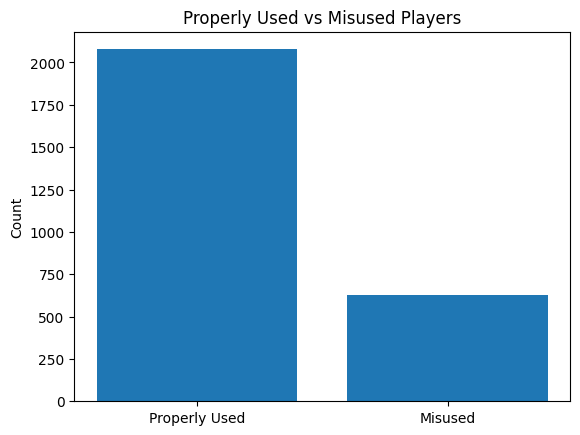

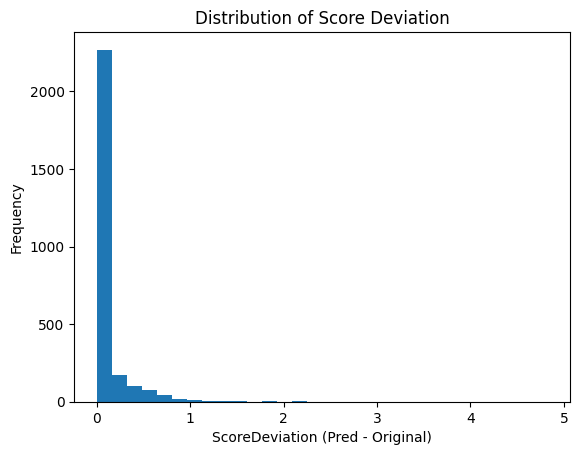

In [64]:
# === Deviation metrics ===
# 1) Raw deviation: PredScore - OriginalScore
def original_score(row):
    if row["PosGroup"] == "FW":
        return row["AttackScore"]
    if row["PosGroup"] == "MF":
        return row["MidScore"]
    return row["DefScore"]

def pred_score(row):
    if row["PredGroup"] == "FW":
        return row["AttackScore"]
    if row["PredGroup"] == "MF":
        return row["MidScore"]
    return row["DefScore"]

df_scores["OriginalScore"] = df_scores.apply(original_score, axis=1)
df_scores["PredScore"] = df_scores.apply(pred_score, axis=1)
df_scores["ScoreDeviation"] = df_scores["PredScore"] - df_scores["OriginalScore"]

# 2) Z-score style: compare each player's relevant score to distribution of that group
group_stats = df_scores.groupby("PosGroup")[["AttackScore","MidScore","DefScore"]].agg(["mean","std"])

def z_vs_group(score_col, group, value):
    m = group_stats.loc[group, (score_col, "mean")]
    s = group_stats.loc[group, (score_col, "std")]
    if s == 0 or np.isnan(s):
        return 0.0
    return (value - m) / s

pred_z = []
orig_z = []
for _, r in df_scores.iterrows():
    pred_col = {"FW":"AttackScore","MF":"MidScore","DF":"DefScore"}[r["PredGroup"]]
    orig_col = {"FW":"AttackScore","MF":"MidScore","DF":"DefScore"}[r["PosGroup"]]
    pred_z.append(z_vs_group(pred_col, r["PredGroup"], r[pred_col]))
    orig_z.append(z_vs_group(orig_col, r["PosGroup"], r[orig_col]))

df_scores["PredScoreZ"] = pred_z
df_scores["OriginalScoreZ"] = orig_z

misused_df = df_scores[df_scores["Misused"]].copy().sort_values("ScoreDeviation", ascending=False)

print("Misused players:", len(misused_df))
display(misused_df.head(30))

misuse_counts = df_scores["Misused"].value_counts()

plt.figure()
plt.bar(["Properly Used","Misused"], misuse_counts.sort_index().values)
plt.title("Properly Used vs Misused Players")
plt.ylabel("Count")
plt.show()


plt.figure()
plt.hist(df_scores["ScoreDeviation"], bins=30)
plt.title("Distribution of Score Deviation")
plt.xlabel("ScoreDeviation (Pred - Original)")
plt.ylabel("Frequency")
plt.show()


In [66]:
# === Export to Excel ===
out_path = Path("misuse_analysis.xlsx")

pos_counts = df["Pos"].value_counts().rename_axis("Pos").reset_index(name="Count")
comp_counts = df["Comp"].value_counts().rename_axis("Comp").reset_index(name="Count")


misused_out = misused_df[[
    "Player","Comp","Pos","PosGroup","PredGroup",
    "AttackScore","MidScore","DefScore",
    "ScoreDeviation","PredScoreZ","OriginalScoreZ"
]].copy()

with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    df_scores.to_excel(writer, index=False, sheet_name="AllPlayerScores")
    misused_out.to_excel(writer, index=False, sheet_name="MisusedPlayers")

print("Wrote:", out_path.resolve())


Wrote: /mnt/d/Code/japeto/FD/player_position_kpis_misuse_analysis.xlsx
